<a href="https://colab.research.google.com/github/etuckerman/syllabus_extraction_NLP/blob/main/USF_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-docx PyPDF2 spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import re
import spacy
import json
from PyPDF2 import PdfReader
from docx import Document

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function to extract text from a PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

# Function to extract text from a DOCX
def extract_text_from_docx(docx_path):
    text = ""
    doc = Document(docx_path)
    for paragraph in doc.paragraphs:
        text += paragraph.text + "\n"
    return text

# Function to find dates, events, and descriptions
def extract_events(text):
    # Regex pattern for date matching
    date_pattern = r'\b(?:Mon|Tues|Wed|Thu|Fri|Sat|Sun)?,? (Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\.?\s*\d{1,2}\b'

    events = []

    # Process the text with SpaCy
    doc = nlp(text)

    for sent in doc.sents:
        # Extract dates using regex
        regex_dates = re.findall(date_pattern, sent.text)

        # Check for date entities from NER
        ner_dates = [ent.text for ent in sent.ents if ent.label_ == "DATE"]

        # Combine both date findings
        all_dates = set(regex_dates + ner_dates)

        for date in all_dates:
            # Assuming the event name is on the same line after the date
            event_start = sent.text.find(date) + len(date)
            remaining_text = sent.text[event_start:].strip()

            # Extract event name and description
            if remaining_text:
                # Split by new lines or additional spaces to get clearer separation
                lines = remaining_text.split('\n')
                event_name = lines[0].strip()  # Take the first line as event name

                # Assume all lines following the event name could be a description
                description = "\n".join(line.strip() for line in lines[1:] if line.strip())

                # Handle cases where multiple dates are in a single event
                if ',' in date:  # Check if multiple dates are present
                    split_dates = [d.strip() for d in date.split(',')]
                    for split_date in split_dates:
                        events.append({
                            "Event Name": event_name,
                            "Event Date": split_date,
                            "Description": description
                        })
                else:
                    events.append({
                        "Event Name": event_name,
                        "Event Date": date,
                        "Description": description
                    })

    return events

# Main function to process PDF and DOCX files
def process_syllabi(pdf_path, docx_path):
    pdf_text = extract_text_from_pdf(pdf_path)
    docx_text = extract_text_from_docx(docx_path)

    all_events = []
    all_events.extend(extract_events(pdf_text))
    all_events.extend(extract_events(docx_text))

    return all_events

# Save events to a JSON file
def save_events_to_json(events, json_file_path):
    with open(json_file_path, 'w') as json_file:
        json.dump(events, json_file, indent=4)

# Example usage
pdf_path = '/content/EGN3443 Fall 2024 Li & Gobes-Ryan.pdf'
docx_path = '/content/CAP4530 001-syllabus_Fall2024.docx'
json_output_path = '/content/extracted_events.json'  # Specify the output JSON file path

events = process_syllabi(pdf_path, docx_path)

# Save extracted events to JSON
save_events_to_json(events, json_output_path)

# Print a confirmation message
print(f"Extracted events saved to {json_output_path}")


Extracted events saved to /content/extracted_events.json


In [3]:
import pandas as pd
from docx import Document

# Function to extract table data from a DOCX file and convert it to a DataFrame
def extract_table_to_dataframe(docx_path):
    # Load the document
    doc = Document(docx_path)

    # Assume the first table in the document is the one we want
    table = doc.tables[0]

    # Extracting data from the table
    data = []

    for row in table.rows:
        # Extract each cell in the row and strip any extra whitespace
        row_data = [cell.text.strip() for cell in row.cells]
        data.append(row_data)

    # Create a DataFrame, assuming the first row is the header
    df = pd.DataFrame(data[1:], columns=data[0])  # Skip the first row for data
    return df

# Example usage
docx_path = 'test_table.docx'  # Path to your DOCX file
df = extract_table_to_dataframe(docx_path)

# Display the DataFrame
print(df)

# Optionally, you can save the DataFrame to a CSV file
csv_output_path = 'table_data.csv'
df.to_csv(csv_output_path, index=False)

print(f"Table data saved to {csv_output_path}")


                       Day                                              Topic  \
0       Tues, Aug\n     27                                                C++   
1              Thu, Aug 29  OO Software Development \nADT, Templated Funct...   
2              Tues, Sep.3                                            Arrays,   
3              Thu, Sep. 5                                       Linked Lists   
4    Tues, Sep.\n       10                            Linked Lists (continue)   
5      Thu, Sep.\n      12                           Recursion and \nAnalysis   
6     Tues, Sep.\n      17                                             Stacks   
7             Thu, Sep. 19                                   Queues and Deque   
8            Tues, Sep. 24                                  Review for exam 1   
9             Thu, Sep. 26                                             Exam 1   
10       Tues, Oct.\n    1             Lists and Iterators\n\nTowers of Hanoi   
11             Thu, Oct. 3  

In [4]:
import pandas as pd
import re
import json
from datetime import datetime

# Sample input data
data = df

# Function to parse the syllabus data
def parse_syllabus(data):

    events = []

    # Regex pattern for matching dates
    date_pattern = re.compile(r'\b(?:\w{3}\.?\s\d{1,2})\b')

    for index, row in df.iterrows():
        day = row['Day']
        topic = row['Topic']
        due = row['Due']
        notice = row['Notice']

        # Identify the date in the 'Day' column
        if date_pattern.search(day):
            event_date = date_pattern.search(day).group(0)

            # Normalize the date format
            try:
                event_date = datetime.strptime(event_date, '%b. %d').strftime('%B %d')  # e.g., "Aug. 27" to "August 27"
            except ValueError:
                continue  # Skip invalid date formats

            event_name = topic.strip()
            description = notice.strip() if notice else None  # Use notice as description if available

            # Append the extracted event to the list
            events.append({
                'Event Name': event_name,
                'Event Date': event_date,
                'Description': description
            })

    return events

# Parse the syllabus
parsed_events = parse_syllabus(data)

# Convert to JSON format
output_json = json.dumps(parsed_events, indent=4)

# Print the output
print(output_json)

# Optionally, save the output to a JSON file
with open('extracted_events.json', 'w') as json_file:
    json.dump(parsed_events, json_file, indent=4)

print("Extracted events saved to extracted_events.json")


[
    {
        "Event Name": "Linked Lists",
        "Event Date": "September 05",
        "Description": null
    },
    {
        "Event Name": "Queues and Deque",
        "Event Date": "September 19",
        "Description": null
    },
    {
        "Event Name": "Review for exam 1",
        "Event Date": "September 24",
        "Description": "PP2 opens until Oct. 6 at 11:59pm"
    },
    {
        "Event Name": "Exam 1",
        "Event Date": "September 26",
        "Description": "In class"
    },
    {
        "Event Name": "Trees and Traversal",
        "Event Date": "October 03",
        "Description": null
    },
    {
        "Event Name": "Exam 2",
        "Event Date": "October 24",
        "Description": null
    },
    {
        "Event Name": "Binary Search and AVL",
        "Event Date": "October 29",
        "Description": "PP4 opens until Nov. 13"
    },
    {
        "Event Name": "Functional Programming",
        "Event Date": "November 14",
        "Description": 

In [5]:
!pip install pytesseract opencv-python pdf2image


In [6]:
import re
import json
import PyPDF2

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    text = ""
    with open(pdf_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

def clean_text(text):
    """Clean the extracted text by normalizing spaces without removing line breaks."""
    text = re.sub(r'[ ]+', ' ', text)  # Replace only consecutive spaces, preserving newlines
    return text

def extract_chapter_descriptions(text):
    """Extract chapter descriptions from the text."""
    chapter_descriptions = {}

    # Regex to match chapters in the format "Ch. 1 – Topic"
    chapter_pattern = r'(Ch\. \d+)\s*–\s*([^Ch]+)'  # Match chapter and topic until the next 'Ch'

    matches = re.findall(chapter_pattern, text)
    for match in matches:
        chapter_number = match[0].strip().replace(" ", "")  # Remove spaces for consistency
        topic = match[1].strip()  # Extract topic description
        chapter_descriptions[chapter_number] = topic  # Store chapter as key and description as value

    # Remove the chapter descriptions from the text after extracting
    cleaned_text = re.sub(chapter_pattern, '', text)

    return chapter_descriptions, cleaned_text

def parse_schedule(text):
    """Parse the cleaned text into weeks with dates and events."""
    # Clean the text first
    text = clean_text(text)

    # Split lines and clean up the text
    lines = text.split('\n')
    lines = [line.strip() for line in lines if line.strip()]

    # Filter out irrelevant lines
    skip_patterns = [
        r'Page \d+ of \d+',  # Header/footer patterns
        r'Tentative Class Schedule',  # Header content
        r'Section \d+',  # Section numbers
        r'Week\s+',  # Week headers
    ]

    filtered_lines = []
    for line in lines:
        # Skip lines matching any of the skip patterns
        if any(re.search(pattern, line) for pattern in skip_patterns):
            continue
        filtered_lines.append(line)

    # Regex patterns for matching dates and numbers
    date_pattern = r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sept|Oct|Nov|Dec)\.?\s\d{1,2}'
    week_pattern = r'^\d+\s'  # Matches week numbers

    schedule = []
    current_week = {}
    current_events = []

    for line in filtered_lines:
        # Detect week start by matching week pattern like "1 Aug. 27 Aug. 29 Aug. 30"
        if re.match(week_pattern, line):
            # If we are in a new week, save the previous week's data
            if current_week:
                current_week["events"] = current_events
                schedule.append(current_week)
                current_week = {}
                current_events = []

            # Extract dates from the line
            dates = re.findall(date_pattern, line)
            if dates:
                current_week["dates"] = dates

        # If it's not a week start, assume it's an event line
        else:
            current_events.append(line)

    # Append the last week's data after loop ends
    if current_week:
        current_week["events"] = current_events
        schedule.append(current_week)

    return schedule

def format_schedule(parsed_schedule, chapter_descriptions):
    """Format parsed schedule into the desired JSON structure with chapter descriptions."""
    formatted_schedule = []

    for week in parsed_schedule:
        dates = week.get("dates", [])
        events = week.get("events", [])

        for event in events:
            # Clean parentheses and normalize 'Ch . ' to 'Ch.'
            event_cleaned = re.sub(r'\s*\(\s*|\s*\)\s*', '', event)  # Remove parentheses
            event_cleaned = re.sub(r'Ch\s*\.\s*', 'Ch.', event_cleaned)  # Normalize 'Ch . ' to 'Ch.'
            event_cleaned = event_cleaned.strip()  # Remove leading/trailing whitespace

            # Split the event into sub-events using '+' and '/' while keeping them grouped by date
            sub_events = re.split(r'\s*[\+/]\s*', event_cleaned)

            for i, sub_event in enumerate(sub_events):
                # Check for multiple chapter references and gather their descriptions
                description = []

                # Find all chapter references in the sub_event
                chapters_in_event = re.findall(r'(Ch\.\d+)', sub_event)  # Updated regex to match 'Ch.1', 'Ch.2', etc.

                for chapter in chapters_in_event:
                    chapter_key = chapter.strip()  # Normalize spaces around chapter references
                    if chapter_key in chapter_descriptions:
                        description.append(chapter_descriptions[chapter_key])

                # Join multiple chapter descriptions
                description_text = " | ".join(description)

                # Assign the first sub-event to the first date, second sub-event to the second date, etc.
                event_data = {
                    "Event Name": sub_event.strip(),
                    "Event Date": dates[i].strip() if i < len(dates) else dates[-1],  # Last date for remaining events
                    "Description": description_text
                }
                formatted_schedule.append(event_data)

    return formatted_schedule



# Extract and clean the PDF text
pdf_path = 'test_pdf_table.pdf'
extracted_text = extract_text_from_pdf(pdf_path)

# Extract chapter descriptions
chapter_descriptions, cleaned_text = extract_chapter_descriptions(extracted_text)

# Parse the text into schedule data
parsed_schedule = parse_schedule(cleaned_text)

# Format the parsed data into JSON format with chapter descriptions
formatted_schedule = format_schedule(parsed_schedule, chapter_descriptions)

# Output the formatted schedule as JSON
print(json.dumps(formatted_schedule, indent=4))


[
    {
        "Event Name": "Course Introduction",
        "Event Date": "Aug. 27",
        "Description": ""
    },
    {
        "Event Name": "Ch.1 Ch.1 IDL Start Up Module",
        "Event Date": "Aug. 29",
        "Description": "Descriptive statistics | Descriptive statistics"
    },
    {
        "Event Name": "Workshop 1",
        "Event Date": "Aug. 27",
        "Description": ""
    },
    {
        "Event Name": "Ch.1",
        "Event Date": "Sept. 3",
        "Description": "Descriptive statistics"
    },
    {
        "Event Name": "Ch.2 Ch.2 Recitation Session #1",
        "Event Date": "Sept. 5",
        "Description": "Probability | Probability"
    },
    {
        "Event Name": "Ch.2 Ch.3 Quiz #1Ch.1",
        "Event Date": "Sept. 10",
        "Description": "Probability | Discrete Random Variables | Descriptive statistics"
    },
    {
        "Event Name": "Ch.2",
        "Event Date": "Sept. 12",
        "Description": "Probability"
    },
    {
        "Event Na

In [7]:
print(parsed_schedule)

[{'dates': ['Aug. 27', 'Aug. 29', 'Aug. 30'], 'events': ['Course Introduction + Ch . 1 Ch. 1 IDL Start Up Module', 'Workshop 1']}, {'dates': ['Sept. 3', 'Sept. 5', 'Sept. 6'], 'events': ['Ch. 1 + Ch. 2 Ch. 2 Recitation Session #1']}, {'dates': ['Sept. 10', 'Sept. 12', 'Sept. 13'], 'events': ['Ch. 2 Ch. 3 Quiz #1 (Ch . 1 + Ch . 2)']}, {'dates': ['Sept. 17', 'Sept. 19', 'Sept. 20'], 'events': ['IDL 1 Data Visualization +', 'Workshop 2 Ch. 3 Recitation Session # 2']}, {'dates': ['Sept. 24', 'Sept. 26', 'Sept. 27'], 'events': ['Ch. 3 Ch. 3 /Ch. 4 + IDL 1 Argument Recitation Session # 3']}, {'dates': ['Oct. 1', 'Oct. 3', 'Oct. 4'], 'events': ['Ch. 4 Ch. 4 Quiz #2 (Ch . 3 + Ch . 4)']}, {'dates': ['Oct. 8', 'Oct. 10', 'Oct. 11'], 'events': ['Ch. 4 Midterm Review Workshop 3']}, {'dates': ['Oct. 1', 'Oct. 17', 'Oct. 18'], 'events': ['Midterm Exam', '(Ch1+Ch2+Ch3+Ch4) Ch. 7 Recitation Session # 4']}, {'dates': ['Oct. 22', 'Oct. 24', 'Oct. 25'], 'events': ['IDL 2 Data Visualization +', 'Workshop 

In [8]:
print(chapter_descriptions)

{'Ch.1': 'Descriptive statistics', 'Ch.2': 'Probability', 'Ch.3': 'Discrete Random Variables', 'Ch.4': '', 'Ch.7': 'Statistical Intervals', 'Ch.8': 'Hypot', 'Ch.12': 'Linear Regression'}


In [9]:
# Load docx data from extracted_events.json
with open('extracted_events.json', 'r') as json_file:
    docx_data = json.load(json_file)

# Create final JSON output with docx and pdf sections
final_json = {
    "pdf": formatted_schedule,
    "docx": docx_data
}

# Output the final structured JSON
print(json.dumps(final_json, indent=4))

with open('combined_json.json', 'w') as f:
    json.dump(final_json, f, indent=4)

print("Combined JSON saved to combined_json.json")

{
    "pdf": [
        {
            "Event Name": "Course Introduction",
            "Event Date": "Aug. 27",
            "Description": ""
        },
        {
            "Event Name": "Ch.1 Ch.1 IDL Start Up Module",
            "Event Date": "Aug. 29",
            "Description": "Descriptive statistics | Descriptive statistics"
        },
        {
            "Event Name": "Workshop 1",
            "Event Date": "Aug. 27",
            "Description": ""
        },
        {
            "Event Name": "Ch.1",
            "Event Date": "Sept. 3",
            "Description": "Descriptive statistics"
        },
        {
            "Event Name": "Ch.2 Ch.2 Recitation Session #1",
            "Event Date": "Sept. 5",
            "Description": "Probability | Probability"
        },
        {
            "Event Name": "Ch.2 Ch.3 Quiz #1Ch.1",
            "Event Date": "Sept. 10",
            "Description": "Probability | Discrete Random Variables | Descriptive statistics"
        },
    

In [10]:
!pip install transformers torch


In [11]:
import json
from transformers import pipeline

def clean_text_with_model(input_json):
    # Load the summarization pipeline with a smaller model
    summarizer = pipeline("summarization", model="facebook/bart-base")

    # Convert input JSON string to dictionary
    data = json.loads(input_json)

    # Iterate through the docx and pdf entries to clean up text
    for section in ['docx', 'pdf']:
        if section in data:
            for item in data[section]:
                # Combine the text to clean up punctuation
                text_to_clean = f"{item['Event Name']} {item['Description']}"

                # Use the model to generate cleaned-up text
                cleaned_text = summarizer(text_to_clean, max_length=100, min_length=5, do_sample=False)[0]['summary_text']

                # Update the item with the cleaned text
                item['Event Name'], item['Description'] = cleaned_text.split(' ', 1)  # Assuming the split returns a valid format

    return json.dumps(data, indent=4)

def load_json_file(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as file:
        return file.read()

# Load JSON data from combined_json.json
input_json = load_json_file('combined_json.json')

# Clean the JSON data using the model
cleaned_json = clean_text_with_model(input_json)

# Print the cleaned JSON
print(cleaned_json)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Your max_length is set to 100, but your input_length is only 6. Since this is a summarizati

{
    "pdf": [
        {
            "Event Name": "Course",
            "Event Date": "Aug. 27",
            "Description": "Introduction "
        },
        {
            "Event Name": "Ch.1",
            "Event Date": "Aug. 29",
            "Description": "Ch.1 IDL Start Up Module Descriptive statistics | Descriptives statistics"
        },
        {
            "Event Name": "Workshop",
            "Event Date": "Aug. 27",
            "Description": "1 "
        },
        {
            "Event Name": "Ch.1",
            "Event Date": "Sept. 3",
            "Description": "Descriptive statistics"
        },
        {
            "Event Name": "Ch.2",
            "Event Date": "Sept. 5",
            "Description": "Ch.2 Recitation Session #1 Probability | Probability"
        },
        {
            "Event Name": "Ch.2",
            "Event Date": "Sept. 10",
            "Description": "Ch.3 Quiz #1Ch.1 Probability | Discrete Random Variables | Descriptive statistics"
        },
   

In [12]:
!pip install pandas matplotlib seaborn


Total events extracted: 49
Events with empty descriptions: 7
Event counts by chapter:
0
Ch.4     4
Ch.2     3
Ch.7     3
Ch.1     2
Ch.3     2
Ch.8     2
Ch.12    2
Name: count, dtype: int64


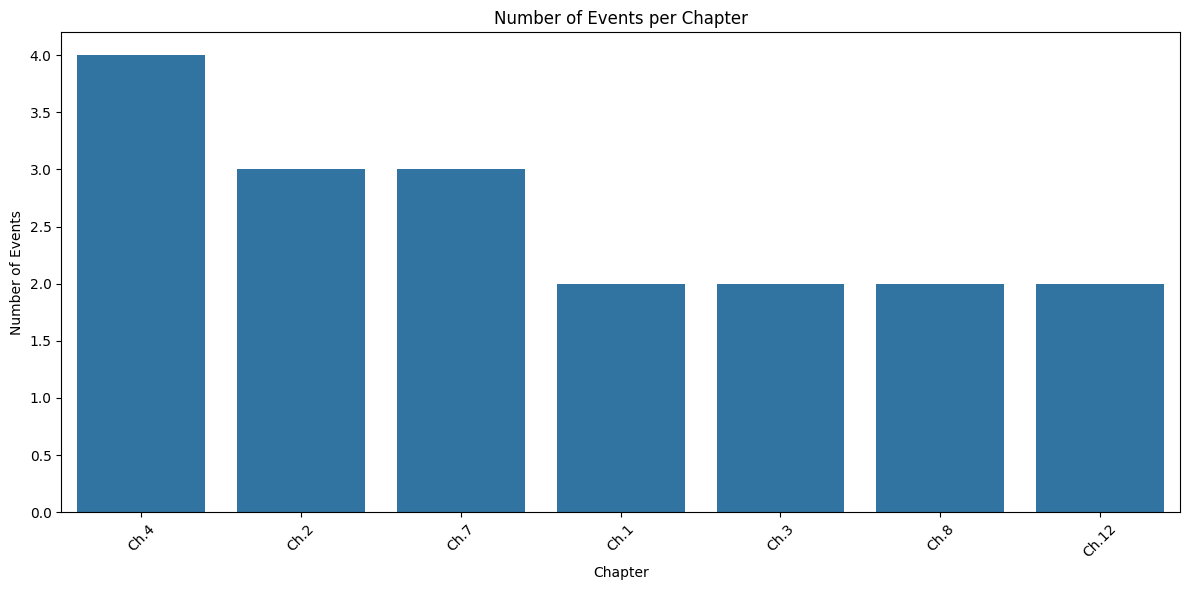

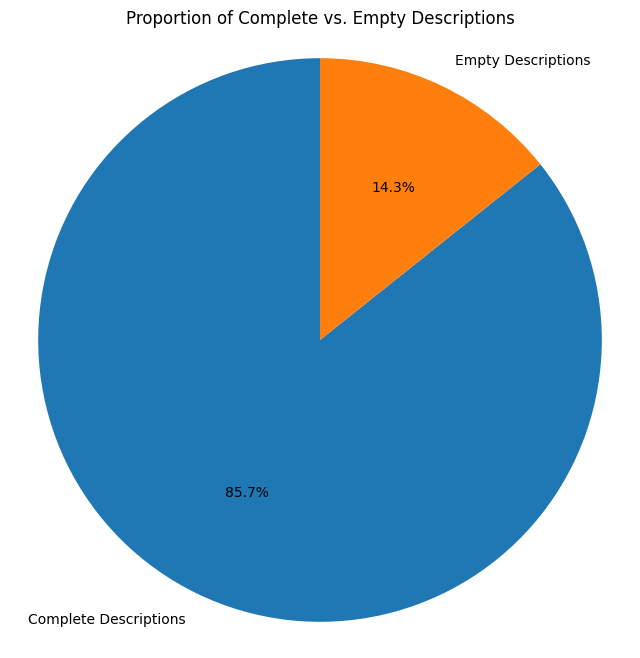

In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined JSON data
with open('combined_json.json', 'r') as f:
    data = json.load(f)

# Flatten the data into a DataFrame
pdf_events = pd.DataFrame(data['pdf'])
docx_events = pd.DataFrame(data['docx'])

# Combine both DataFrames for comprehensive analysis
all_events = pd.concat([pdf_events, docx_events], keys=['PDF', 'DOCX']).reset_index(level=0).rename(columns={'level_0': 'Source'})

# 1. Summary Statistics
total_events = all_events.shape[0]
print(f"Total events extracted: {total_events}")
print(f"Events with empty descriptions: {all_events['Description'].isnull().sum()}")

# Count events per chapter
chapter_counts = all_events['Event Name'].str.extract(r'(Ch\.\d+)')[0].value_counts().fillna(0)
print("Event counts by chapter:")
print(chapter_counts)

# 2. Visualizations
# Bar Chart of Events per Chapter
plt.figure(figsize=(12, 6))
sns.barplot(x=chapter_counts.index, y=chapter_counts.values)
plt.title('Number of Events per Chapter')
plt.xlabel('Chapter')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie Chart for Completeness of Descriptions
description_counts = all_events['Description'].isnull().value_counts()
plt.figure(figsize=(8, 8))
plt.pie(description_counts, labels=['Complete Descriptions', 'Empty Descriptions'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Complete vs. Empty Descriptions')
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular.
plt.show()
